# Introduction

In this tutorial, you will try to implement a passive reinforcement learning agent. However, to better understand the algorithm itself, it is best to assume nothing about the environment. Therefore, I won't tell you how the environment works, nor the effects of your actions.

The only thing that you will know is that the observations provided by the environment are in the form of tuples $(a, b)$ where $a$ is an integer between $0$ and $55$, $b$ is an integer between $0$ and $36$. Terminal flag can be *True* or *False*. Your actions are integeres between $0$, and $37$. The reward is an integer between $0$ and $55$. I also tell you that the environment is steady and does not change drastically.

We will use the *OpenAI Gym library*. The first thing we need to do is to download the environment, import the library, and register the environment within the library.

In [46]:
!wget https://cw.fel.cvut.cz/wiki/_media/courses/smu/game.py

%matplotlib inline
from game import *
import gym
from gym.envs.registration import register
from gym import wrappers
import numpy as np

register(
    id='smu-rl-env-v0',
    entry_point='game:SMUTutorialEnv'
)
envsimple = gym.make('smu-rl-env-v0')

--2022-03-01 22:38:18--  https://cw.fel.cvut.cz/wiki/_media/courses/smu/game.py
Resolving cw.fel.cvut.cz (cw.fel.cvut.cz)... 147.32.209.247
Connecting to cw.fel.cvut.cz (cw.fel.cvut.cz)|147.32.209.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2746 (2.7K) [application/x-python]
Saving to: ‘game.py.27’

game.py.27          100%[===================>]   2.68K  --.-KB/s    in 0s      

2022-03-01 22:38:18 (157 MB/s) - ‘game.py.27’ saved [2746/2746]



<h1> The passive reinforcement learning agent using temporal difference. </h1>

First, we will implement an agent with a fixed learning rate. We will use a fixed strategy and observe how well it performs. The policy with $20\,\%$ selects action $37$. Otherwise, the agent randomly picks a number; all have the same probability. The policy is not deterministic in this case; however, TD-learning will work anyway.

In [47]:
def policy(observation):
    if observation[1] > 27 or np.random.random() < 0.2:
        return 37
    return np.random.randint(0, 37)

For now, we will use a fixed learning rate to see how the policy performs.

In [48]:
alpha = 0.1

Now we can implement the agent. The TD method follows the pseudocode below:

---
1.   Repeat (for each episode):
 1.   Initialize $s$ as the start state.
 1.   Repeat (for each step):
 <ol>
   <li> $a \gets$ action given by $\pi$ in $s$
   <li> Take action $a$; observe reward $r$, and the next state $s'$
   <li> $\widehat{U}(s) \gets \widehat{U}(s) + \alpha \left( r + \gamma \widehat{U}(s') - \widehat{U}(s) \right)$
   <li> $s \gets s'$
  </ol>
 1. until $s$ is terminal
---



The pseudocode is taken from <a href="https://mitpress.mit.edu/books/reinforcement-learning">Sutton, Barto book, figure 6.1</a>.

First, we need to initialize the number of episodes and discount factor. Pick your own values.

In [49]:
number_of_epochs = 100000 # TODO pick your own number and discount factor
discount_factor = 0.99

The template for the code is provided and is similar to the one you have in your project. Modify the code as handy. Documentation is available on <a href="https://gym.openai.com/docs/">https://gym.openai.com/docs/</a>. You already see method <code>env.reset</code> and <code>env.render</code>. The last important method we will need is <code>env.step</code>. Now, implement the TD learning agent.

In [50]:
# this is the OpenAI Gym environment, you will access
env = wrappers.Monitor(envsimple, 'smurltutorial', force=True, video_callable=False)
# TODO : here, store utility function estimates, i.e., a dictionary, an array or anything else
U = {}

for i in range(number_of_epochs):
    observation = env.reset()
    while True:
        if observation not in U:
            U.update({observation: 0})
        new_observation, reward, done, info = env.step(policy(observation))
        if new_observation not in U:
            U.update({new_observation: 0})
        U.update(observation=(U.get(observation) + alpha*(reward + discount_factor*U.get(new_observation) - U.get(observation))))
        observation = new_observation
        if done:
            break
    # in each step you will need to call method env.step() with the action given
    # by the policy() method above
    
    #env.render() will show you the state of the environment

<h1>Convergence of utility values</h1>

Now when the code works, we need to test it. Copy the code to the cell below and check whether the utility values converged.

*   In each iteration, store the value of the non-terminal state $(10,1)$ to field <code>Us101</code>.
*   Store the maximum update made to $\widehat{U}$ in a single iteration to field <code>maxDelta</code>.

In [51]:
env = wrappers.Monitor(envsimple, 'smurltutorial', force=True, video_callable=False)
# TODO : here, store utility function estimates, i.e., a dictionary, an array or anything else
U = {}
Us101 = np.zeros(number_of_epochs)
maxDelta = np.zeros(number_of_epochs)

for i in range(number_of_epochs):
    observation = env.reset()
    t = False
    max_update = 0
    if observation not in U:
            U[observation] = 0
    # TODO your code here
    while True:
        new_observation, reward, done, info = env.step(policy(observation))
        if new_observation not in U:
            U[new_observation] = 0

        tdTarget = reward

        if not done:
            tdTarget += discount_factor * U[new_observation]

        update = alpha * (tdTarget - U[observation])
        U[observation] += update

        if np.abs(update) > np.abs(max_update):
            max_update = update

        if done:
            break
        observation = new_observation
        t = done
    maxDelta[i] = max_update
    if (4,25) not in U:
        U[(4,25)] = 0
    Us101[i] = U[(4,25)] # TODO :  store the value of a state (you can pick a different one if you want)

Now we will render the utility over time. We will use the <code>matplotlib</code> library and the following utility method.

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_series(arr, fileName = None):
    plt.plot(arr)
    if fileName is not None:
        plt.savefig(fileName)

Now, plot the stored $\widehat{U}$ value history for your selected state.

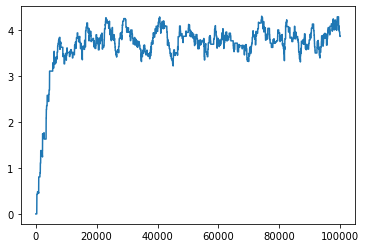

In [53]:
plot_series(Us101)
# put a name of a file as a second parameter if you want to save the figure

We would expect the value to be around $10$. The result may depend on the value of the learning rate. If you get a plot like the following one, the values did not converge.
<center>
  
  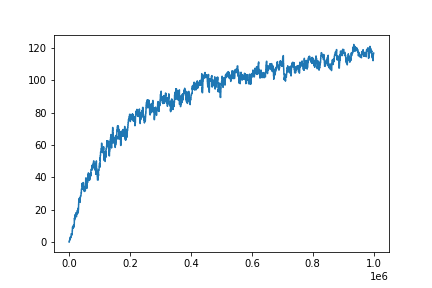

</center>
However, if your results look like the one below, the value for this state is correct. The values don't converge since we set a constant learning rate. The average, however, converges.

<center>

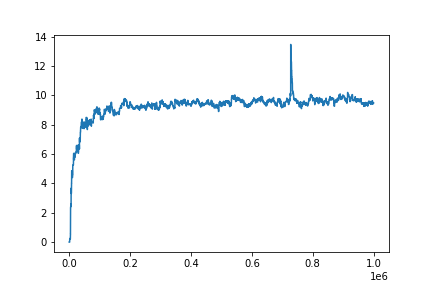

</center>

The value of maximum update to the state utility function is explanatory as well.

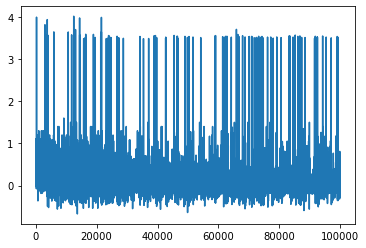

In [54]:
plot_series(maxDelta)

The plot should look like the one below.
<center>
  
  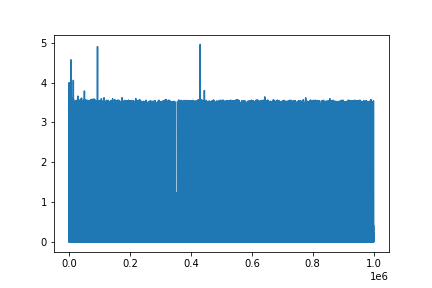

</center>
The utility function did not converge. However, <b>the average values </b> of $\widehat{U}$ converge. (optionally check yourself)

In [55]:
# TODO: optionally check that the average values of $U(s)$ converge

<h1> Decrease the learning rate </h1>
If your state utility function converged in the last section, you are lucky. However, we know the solution from the lecture - the value of learning rate $\alpha$ should be decreasing with the number of trials. More specifically, with the number of visits to the current state. In the last plot, the maximum change was approximately constant over time. As a result, the utility values oscillate.

Therefore, copy the code from the last section to the cell below and choose some function so that the value of learning rate $\alpha$ decreases with the number of visits of a state. Formally, it must hold that
$$ \sum_{k=0}^\infty \alpha_k = \infty $$
and
$$ \sum_{k=0}^\infty \alpha_k^2 < \infty, $$
i.e., the sum of $\alpha_k$ diverges and sum of $\alpha_k^2$ converges. The first condition is needed so that learning can overcome arbitrarily large initial error; the second one eliminates shattering around the value, which we have seen in the last section.

Answer the following question yourself: Why should be learning rate different for each state?

In [56]:
env = wrappers.Monitor(envsimple, 'smurltutorial', force=True, video_callable=False)
U = # TODO : define utility function
Ns = # TODO : this time you have to store the number of visits of each state
Us101 = np.zeros(number_of_epochs)
maxDelta = np.zeros(number_of_epochs)

for i in range(number_of_epochs):
    observation = env.reset()
    # TODO your code here
    #env.render()
    maxDelta[i] = # TODO : store the maximum update to U(s)
    Us101[i] = # TODO :  store the value of a state (you can pick a different one)

SyntaxError: invalid syntax (2653909486.py, line 2)

Rerun your code, this time with $\alpha$ decreasing with the number of visits of a state. Check the result.

In [ ]:
plot_series(Us101)

If your state utility function looks like the one below, you won because the values converged. If not, try again.
<center>
  
  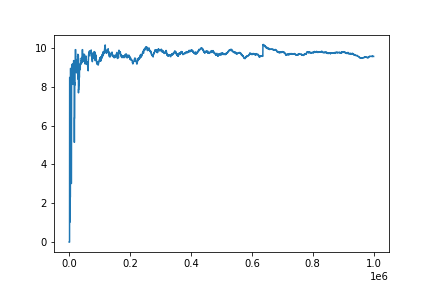

</center>
Hint: <span style="color:white">In AIMA, they use $$\alpha = \frac{c}{c - 1 + \mbox{number of visits}}$$ for a constant $c$

Plot the maximum change in the state utility function.

In [ ]:
plot_series(maxDelta)

We see that the update is decreasing (as expected).
<center>
  
  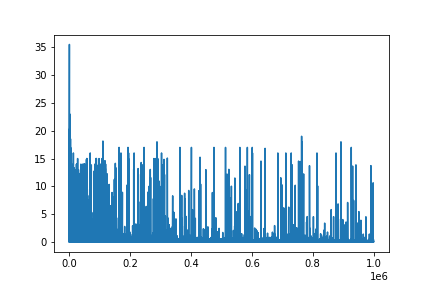

</center>
However, in this case, the result is not nice as the maximum is not robust statistics. Why do we see such high peaks even after $1 000 000$ games played? Compare with the following picture.
<center>
    
   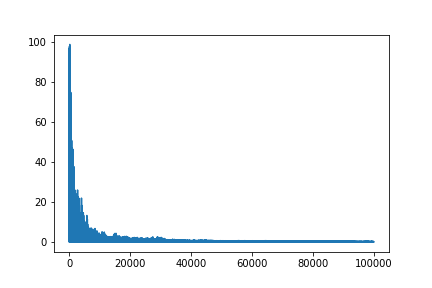

</center>

<h1> Further work </h1>

If you got to this point, could continue yourself without detailed instructions. Here are some ideas of what you may want to do in the remaining time:
<ul>
  <li> Go to <code>game.py</code> file and change the number of states. Does the TD method scale? What is the maximum number of states?
  <li> On <a href="https://gym.openai.com/">https://gym.openai.com/</a> you may find plenty of environments. Pick one and pick one of the strategies that were submitted to the page. Then estimate the state utility function of the strategy.
  <li> Implement the adaptive dynamic programming algorithm and compare it to the TD.
  <li> Whatever you are interested in ...
</ul>